In [85]:
import pyswarms as ps
from pyswarms.utils.plotters import (plot_cost_history)



In [86]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [87]:
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing 
from scipy.io import arff


In [88]:
data = arff.loadarff("./dataset/Medicaldataset.arff")
df = pd.DataFrame(data[0])
df.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64.0,1.0,66.0,160.0,83.0,160.0,1.80,0.012,b'negative'
1,21.0,1.0,94.0,98.0,46.0,296.0,6.75,1.060,b'positive'
2,55.0,1.0,64.0,160.0,77.0,270.0,1.99,0.003,b'negative'
3,64.0,1.0,70.0,120.0,55.0,270.0,13.87,0.122,b'positive'
4,55.0,1.0,64.0,112.0,65.0,300.0,1.08,0.003,b'negative'


In [89]:
#Normalizing and transforming the data
X = df.iloc[:,df.columns !='class'] #select all features except for class
# X = df.iloc[:,df.columns !='class'].to_numpy() #select all features except for class
X_1 = preprocessing.normalize(X, axis=1) #normalizing the features
X_1 = pd.DataFrame(X_1, columns=df.columns[:-1]) #transforming the normalized features to dataframe, w/o the class
#print(X_1)
y = df['class'].str.decode('utf-8') #transform byte to string 
#print(y)
mapping = {'negative': 0, 'positive': 1} #mapping the string to int
y = y.replace(mapping).to_numpy()  #transform string to int
#print(X.shape) (1319, 8) 


Index(['age', 'gender', 'impluse', 'pressurehight', 'pressurelow', 'glucose',
       'kcm', 'troponin'],
      dtype='object')


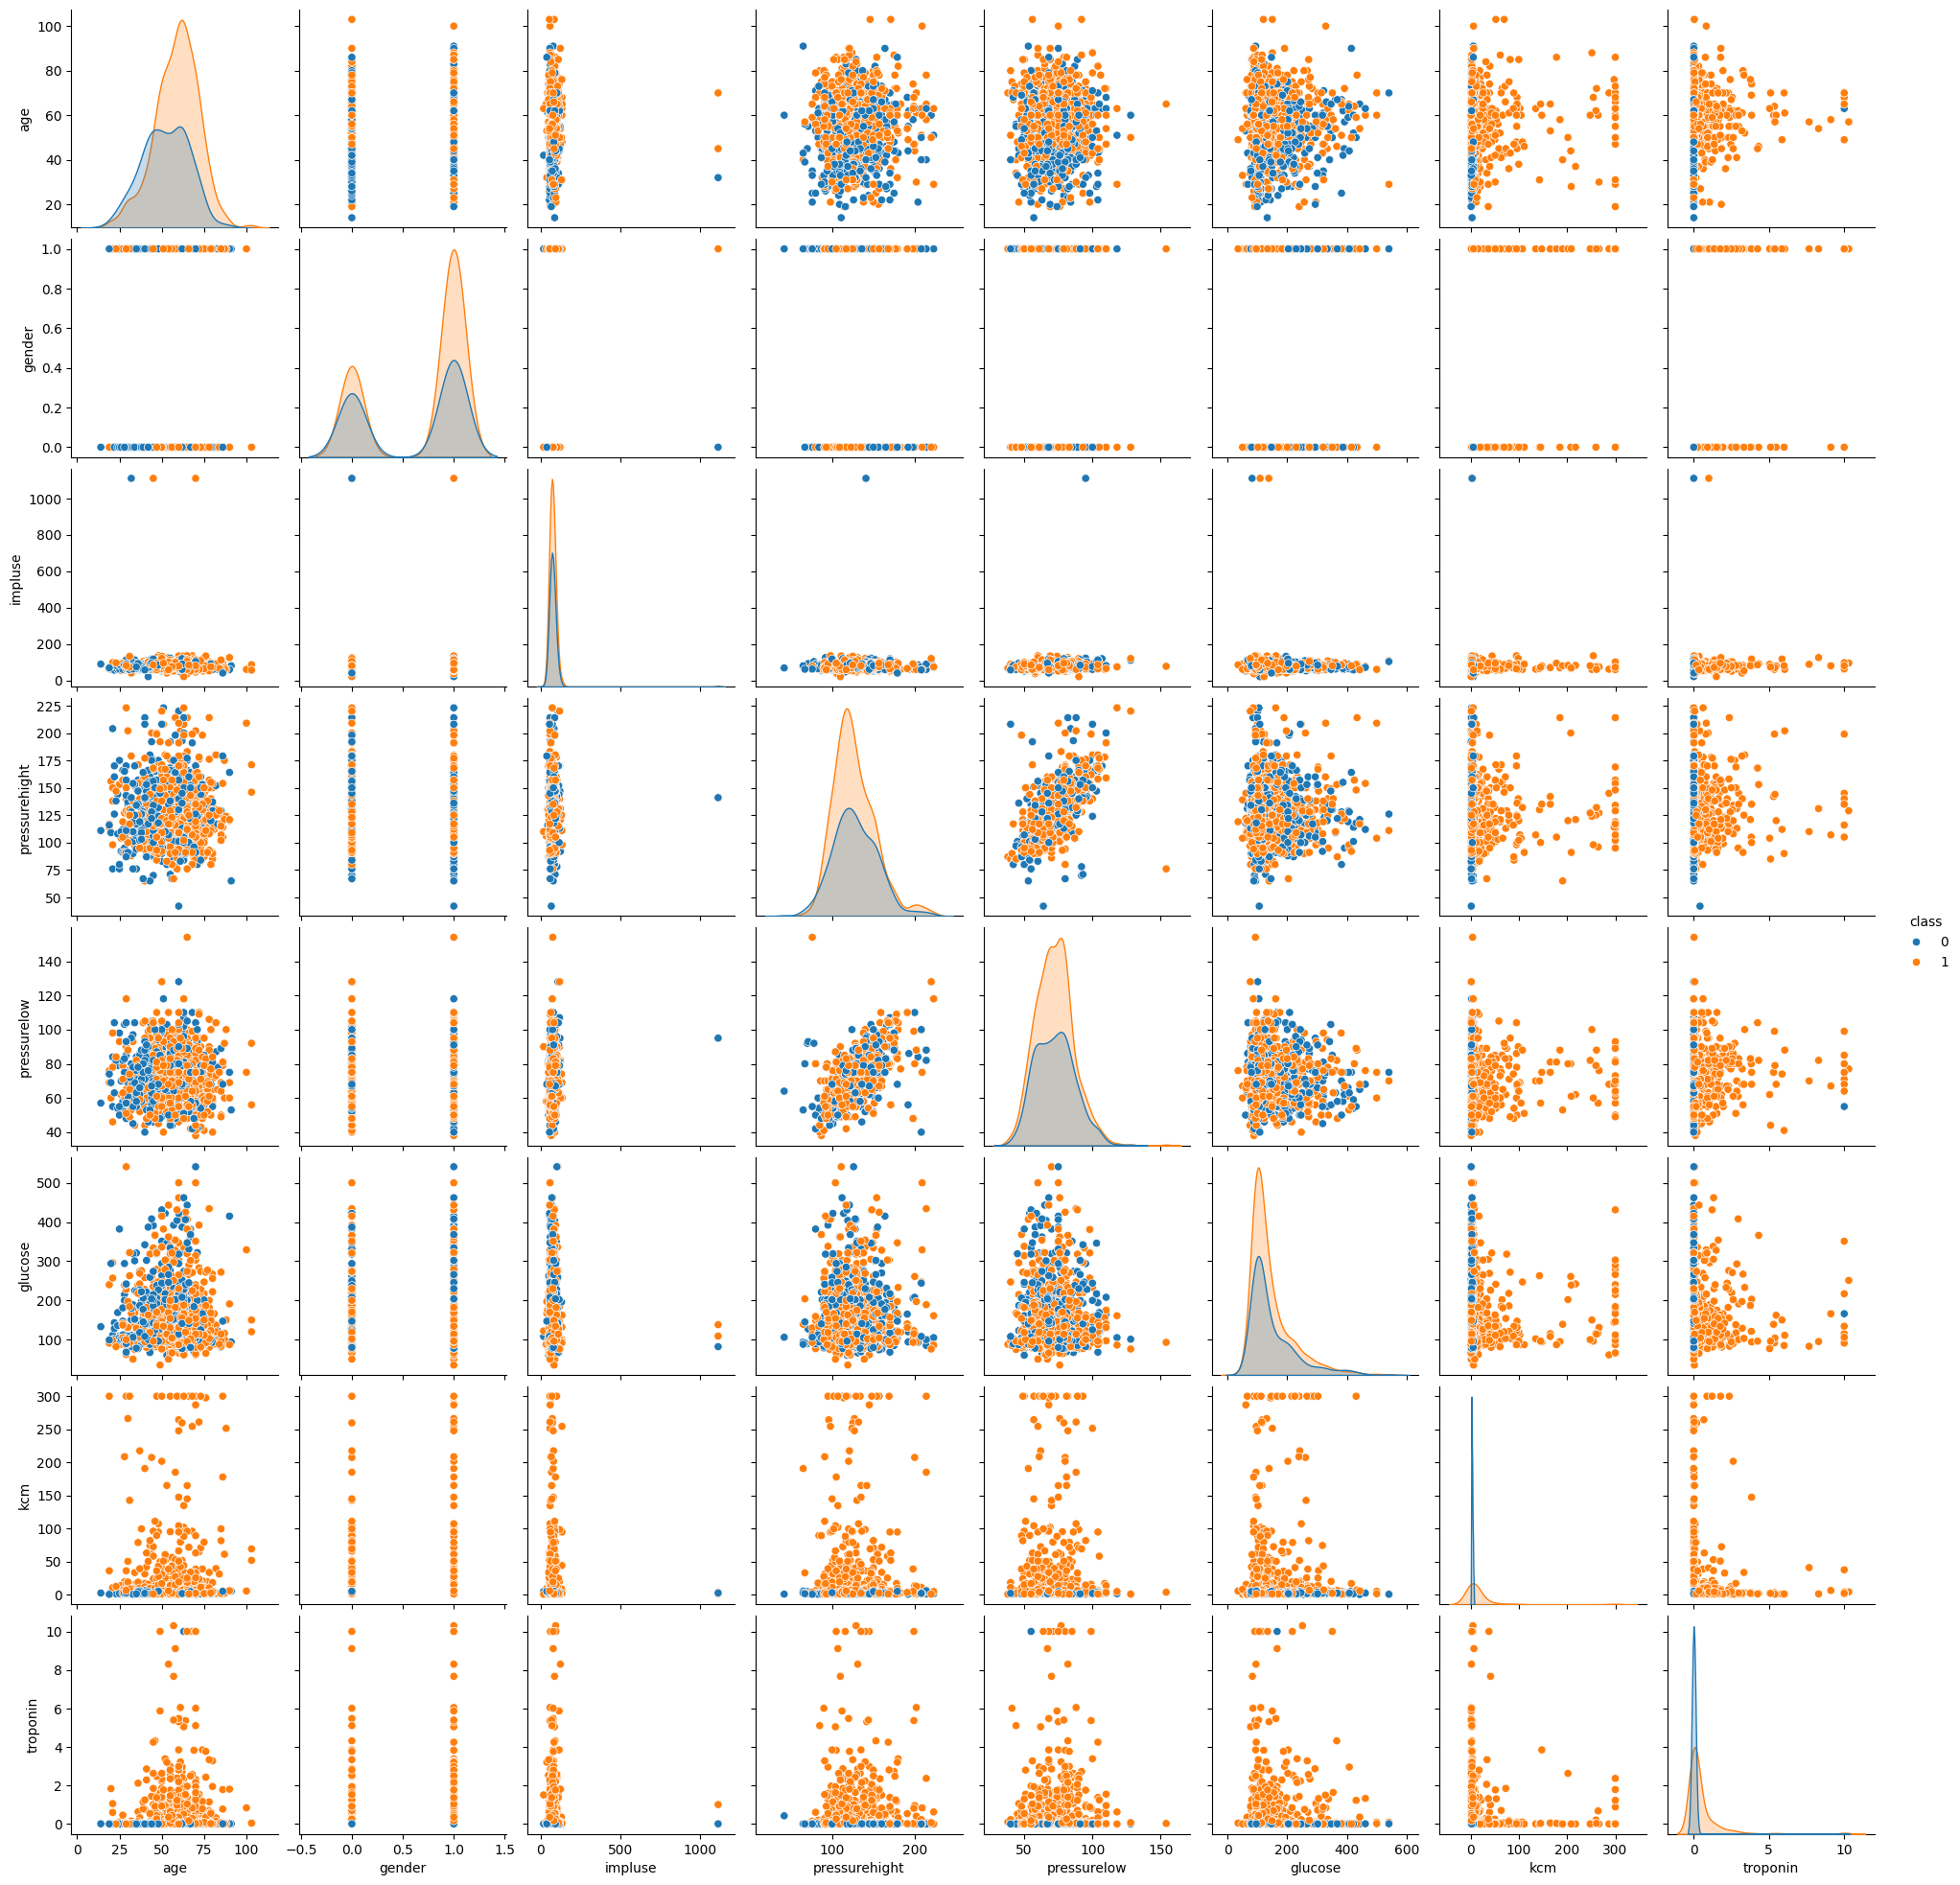

In [95]:
#Visualizing the data
df_1 = pd.DataFrame(X, columns=X.columns)
df_1["class"] = pd.Series(y)
print(X.columns)
sns.pairplot(df_1, hue="class", palette="tab10")

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.33, random_state=42) 

In [ ]:
#Perform feature extraction using Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

# Loop over different values of n_estimators
for n_trees in [50, 100, 200, 500]:
    # Create RandomForestClassifier with current n_estimators
    forest = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    
    # Use cross_val_score for evaluation
    scores = cross_val_score(forest, X_1, y, cv=5)  # 5-fold cross-validation
    mean_score = scores.mean()
    
    print(f"n_estimators={n_trees}, Mean Cross-Validation Score: {mean_score}")



In [ ]:
#Create and train a random forest
forest= RandomForestClassifier(n_estimators= 200, random_state= 42)
forest.fit(X_train, y_train)

#Get the most important features
forest_feats= SelectFromModel(forest, threshold= 'median')
forest_feats.fit(X_train, y_train)

#Get training and development sets that have only the most important features
x_train_forest= forest_feats.transform(X_train)
x_devel_forest= forest_feats.transform(X_test)

#See which features were retained
for i in forest_feats.get_support(indices= True):
    print(X_train.columns[i])

In [ ]:
#Create new dataframes with only the most important features
X_2 = X_1[["age", "glucose", "kcm", "troponin"]]
print(X_2)

In [94]:
# Alternative to normalization processing 
# from sklearn.preprocessing import MinMaxScaler
# features = MinMaxScaler().fit_transform(X)

In [96]:
#Training a classical machine learning model, source: (https://qiskit.org/ecosystem/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html)
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    X_2, y, train_size=0.8, random_state=algorithm_globals.random_seed)

In [97]:
#Train a classical Support Vector Classifier
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [98]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.69
Classical SVC on the test dataset:     0.70


d:\FHNW_Medical_Informatics\Semester Spring 2023\Applied Computational Intelligence\code\.venv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


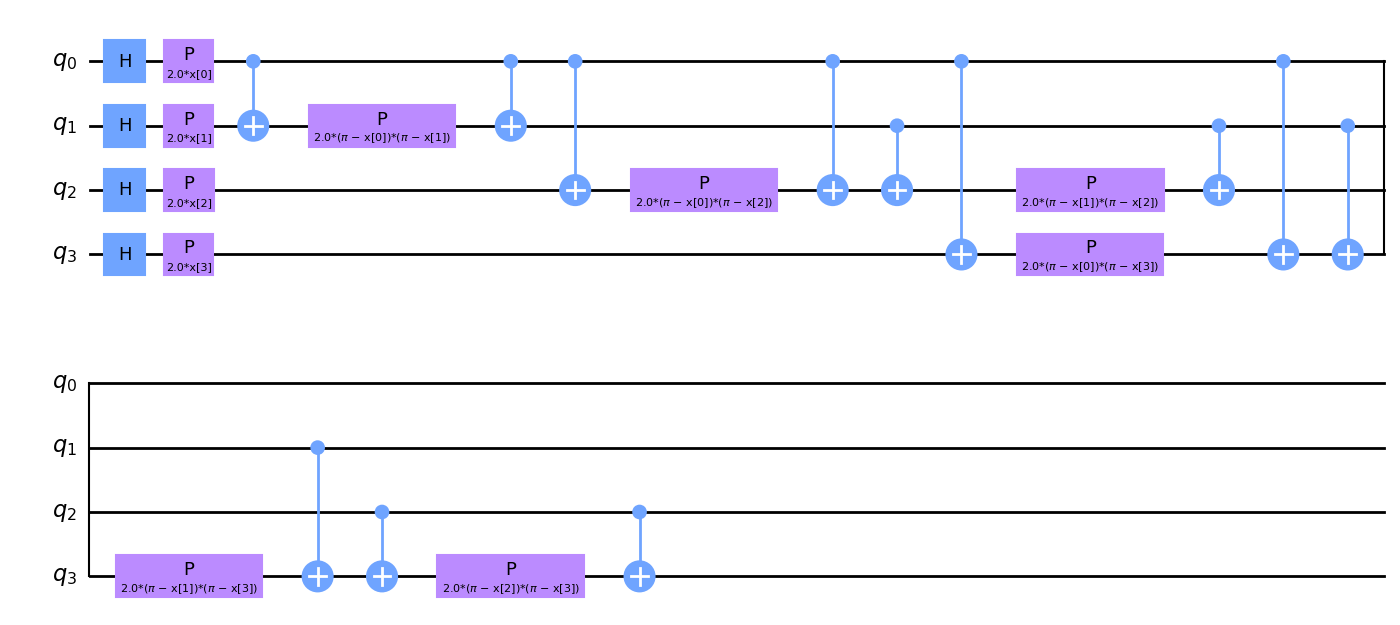

In [99]:
#Training a Quantum Machine Learning Model
from qiskit.circuit.library import ZZFeatureMap

num_features = X_2.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

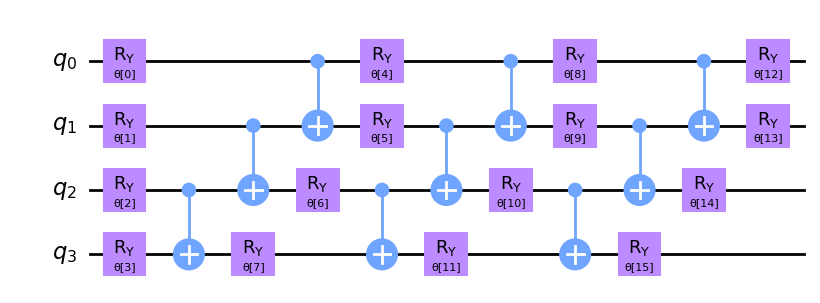

In [100]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [101]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [102]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [103]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

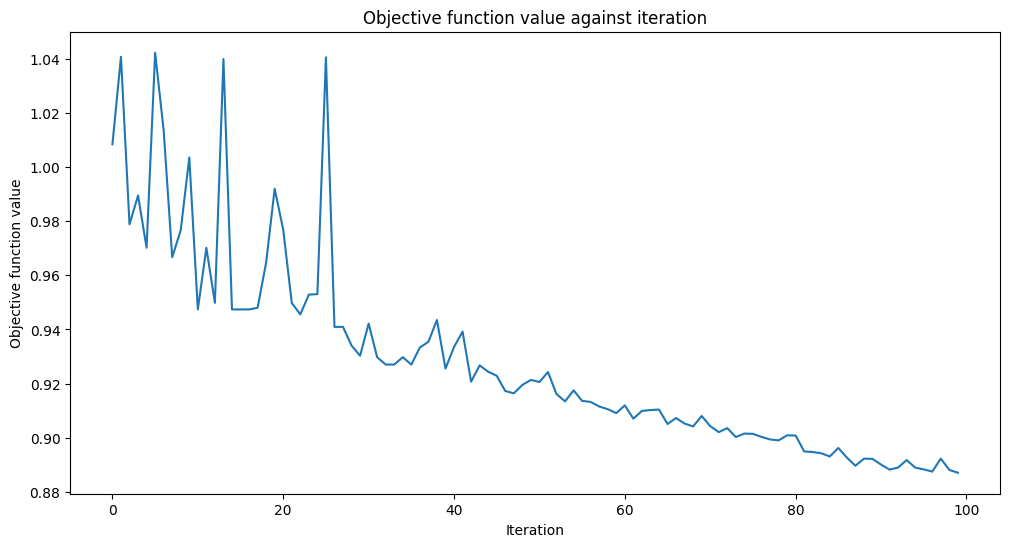

Training time: 1617 seconds


In [104]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [108]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.54
Quantum VQC on the test dataset:     0.47


<Axes: >

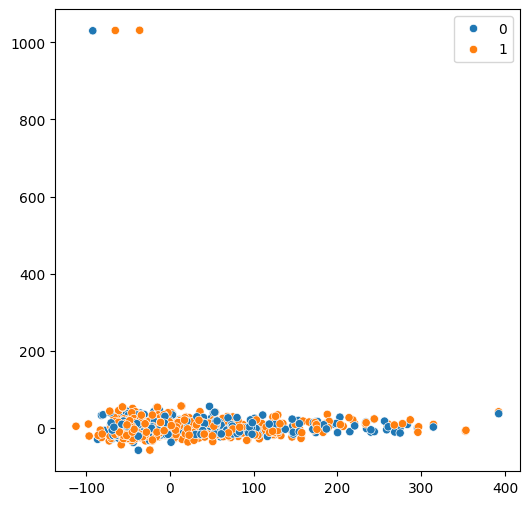

In [109]:
# Think this is incorrect, need to check
from sklearn.decomposition import PCA

features = PCA(n_components=4).fit_transform(X)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=y, palette="tab10")

In [110]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, y, train_size=0.8, random_state=algorithm_globals.random_seed)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.62
Classical SVC on the test dataset:     0.62
